In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf,
# most important is the impotts numpy -> tensorflow -> matplotlib.pyplot
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from lab_utils_common import dlc
# from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [ ]:
def load_coffee_data():
    """ Creates a coffee roasting data set.
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))

    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))


In [ ]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


In [ ]:
def plt_roast(X,Y):
    Y = Y.reshape(-1,)
    colormap = np.array(['r', 'b'])
    fig, ax = plt.subplots(1,1,)
    ax.scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
    ax.scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none',
               edgecolors="blue",linewidth=1,  label="Bad Roast")
    tr = np.linspace(175,260,50)
    ax.plot(tr, (-3/85) * tr + 21, color="blue",linewidth=1)
    ax.axhline(y=12,color="blue",linewidth=1)
    ax.axvline(x=175,color="blue",linewidth=1)
    ax.set_title(f"Coffee Roasting", size=16)
    ax.set_xlabel("Temperature \n(Celsius)",size=12)
    ax.set_ylabel("Duration \n(minutes)",size=12)
    ax.legend(loc='upper right')
    plt.show()

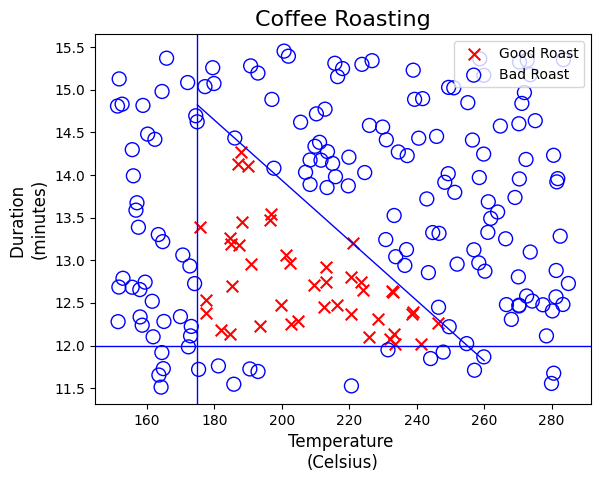

In [ ]:
plt_roast(X,Y)

In [ ]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
# look at the syntax fro normalization (tf -> keras -> layers -> Normalization(axis = -1 )) which is the default one for checking
norm_l = tf.keras.layers.Normalization(axis=-1)


# the very first thing that i will do is the normalization of the data and therefore when i Talk about normalization following is how I would do it
# nomrmalized_layer = tf.keras.layers.Normalziation(axis = -1)

# now we adapt the data to that normalization for example normalized_layer.adapt(X)
# Now we get the data being normalized by X_n = normalized_layer(X)
# so here we get The normaliztion method implemented

# so first setup the layer -> adapt it -> normalize it  and thats it for normalization named as keras Noramlization
norm_l.adapt(X)  # learns mean, variance

# adadt here is allowed to find the mean and std deviation
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


In [ ]:
Xt = np.tile(Xn,(1000,1))
#This was done in order to increase the data set

Yt= np.tile(Y,(1000,1))
print(Xt.shape, Yt.shape)

(200000, 2) (200000, 1)


In [ ]:
tf.random.set_seed(1234)  # applied to achieve consistent results

# now I am going to set up my neural network

#lets see how


#model = tf.keras.Sequenctial([tf.keras.layers.Dense(units = 3, activation = "sigmoid",name = "layer1"),tf.keras.Dense(units = 1, activation = "sigmoid",name = "layer2")])

model = tf.keras.Sequential(
    [
        #We have an Input tensor which is used to tell us what the dimensions of the input vector would be in our case 2 dimensional ones
        #
        tf.keras.Input(shape=(2,)),
        tf.keras.layers.Dense(3, activation='sigmoid', name = 'layer1'),
        tf.keras.layers.Dense(1, activation='sigmoid', name = 'layer2')
     ]
)

In [ ]:
model.summary() #The output is shape is a vector having 3 dimensions

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#These are some default weights on the layers that I have created , Once I fit the model then we can see the answer

W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-0.80189574  0.36506474  0.7133393 ]
 [ 0.823882    0.11683404  0.9578874 ]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[-0.98207086]
 [-0.17690301]
 [-0.5036114 ]] 
b2(1,): [0.]


In [ ]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)
# So here the compile function computes the loss and specifies a comile optimization
# The model fit runs the gradient descent and gets the proper weights

model.fit(
    Xt,Yt,
    epochs=10,
)

Epoch 1/10
6250/6250 [==============================] - 20s 3ms/step - loss: 0.2690
Epoch 2/10
6250/6250 [==============================] - 16s 3ms/step - loss: 0.1154
Epoch 3/10
6250/6250 [==============================] - 16s 3ms/step - loss: 0.0556
Epoch 4/10
6250/6250 [==============================] - 14s 2ms/step - loss: 0.0166
Epoch 5/10
6250/6250 [==============================] - 14s 2ms/step - loss: 0.0104
Epoch 6/10
6250/6250 [==============================] - 14s 2ms/step - loss: 0.0071
Epoch 7/10
6250/6250 [==============================] - 16s 3ms/step - loss: 0.0050
Epoch 8/10
6250/6250 [==============================] - 14s 2ms/step - loss: 0.0035
Epoch 9/10
6250/6250 [==============================] - 15s 2ms/step - loss: 0.0025
Epoch 10/10
6250/6250 [==============================] - 15s 2ms/step - loss: 0.0018


In [ ]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-10.689104     0.14322118  15.145065  ]
 [ -0.30569223  10.791189    12.536465  ]] 
b1: [-11.468157   13.036877    2.1251516]
W2:
 [[-52.707558]
 [ 43.06557 ]
 [-44.128006]] 
b2: [-13.12052]


In [ ]:
W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]] )
b1 = np.array([-9.87, -9.28,  1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])
model.get_layer("layer1").set_weights([W1,b1])
model.get_layer("layer2").set_weights([W2,b2])

In [ ]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = norm_l(X_test)

# if we really quickly notice we can see that the same normalized_layer has used to normalize the data and afterwards the data is predicted
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 [==============================] - 0s 29ms/step
predictions = 
 [[9.625139e-01]
 [3.031606e-08]]


In [ ]:
yhat = np.zeros_like(predictions)
# now this has been set because the number of predictions should match the size
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


In [ ]:
yhat = (predictions >= 0.5).astype(int)
# lets look at this syntax
# yhat = (predictions>=0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


In [ ]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


NameError: name 'plt_layer' is not defined